### Libraries, random seed, wandb installation

In [1]:
%%capture
!pip install uv
!uv pip install --no-deps unsloth vllm==0.8.5.post1
import sys, re, requests; modules = list(sys.modules.keys())
for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
!uv pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
!uv pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer

f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
with open("vllm_requirements.txt", "wb") as file:
    file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
!uv pip install -r vllm_requirements.txt
!uv pip install pympler

In [2]:
import json
import os
import random
import wandb
from collections import defaultdict
import re
from scipy.stats import pearsonr
from pympler import asizeof
import matplotlib.pyplot as plt
import time
import numpy as np
import torch

In [3]:
seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
run_name = "Group_method_with_ans_len_considering_GRPO"

In [5]:
wandb.init(project="GRPO-Reasoning-Length", name=run_name)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jegvide (jegvide-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Unsloth

Load up `Qwen 2.5 0.5B Instruct`, and set parameters

In [6]:
from unsloth import FastLanguageModel, is_bfloat16_supported
import torch
max_seq_length = 1024 # Can increase for longer reasoning traces
lora_rank = 64 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "Qwen/Qwen2.5-0.5B-Instruct",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = True, # Enable vLLM fast inference
    max_lora_rank = lora_rank,
    gpu_memory_utilization = 0.8, # Reduce if out of memory
)

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ], # Remove QKVO if out of memory
    lora_alpha = lora_rank,
    use_gradient_checkpointing = "unsloth", # Enable long context finetuning
    random_state = seed,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 07-21 15:32:04 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 07-21 15:32:04 [__init__.py:239] Automatically detected platform cuda.
Unsloth: Patching vLLM v1 graph capture
Unsloth: Patching vLLM v0 graph capture
==((====))==  Unsloth 2025.7.6: Fast Qwen2 patching. Transformers: 4.53.2. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit with actual GPU utilization = 79.24%
Unsloth: Your GPU has CUDA compute 

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

INFO 07-21 15:32:41 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 07-21 15:32:41 [cuda.py:289] Using XFormers backend.
INFO 07-21 15:32:42 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 07-21 15:32:42 [model_runner.py:1108] Starting to load model unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit...
INFO 07-21 15:32:42 [loader.py:1187] Loading weights with BitsAndBytes quantization. May take a while ...
INFO 07-21 15:32:43 [weight_utils.py:265] Using model weights format ['*.safetensors']


model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

INFO 07-21 15:32:53 [weight_utils.py:281] Time spent downloading weights for unsloth/qwen2.5-0.5b-instruct-unsloth-bnb-4bit: 10.354179 seconds
INFO 07-21 15:32:53 [weight_utils.py:315] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 07-21 15:32:54 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 07-21 15:32:54 [model_runner.py:1140] Model loading took 0.5747 GiB and 12.184376 seconds
INFO 07-21 15:33:04 [worker.py:287] Memory profiling takes 8.72 seconds
INFO 07-21 15:33:04 [worker.py:287] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.79) = 11.68GiB
INFO 07-21 15:33:04 [worker.py:287] model weights take 0.57GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 1.23GiB; the rest of the memory reserved for KV Cache is 9.85GiB.
INFO 07-21 15:33:04 [executor_base.py:112] # cuda blocks: 53816, # CPU blocks: 0
INFO 07-21 15:33:04 [executor_base.py:117] Maximum concurrency for 1024 tokens per request: 840.88x
INFO 07-21 15:33:04 [vllm_utils.py:669] Unsloth: Running patched vLLM v0 `capture_model`.
INFO 07-21 15:33:04 [model_runner.py:1450] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run 

Capturing CUDA graph shapes:   0%|          | 0/31 [00:00<?, ?it/s]

INFO 07-21 15:33:27 [model_runner.py:1592] Graph capturing finished in 22 secs, took 0.43 GiB
INFO 07-21 15:33:27 [vllm_utils.py:676] Unsloth: Patched vLLM v0 graph capture finished in 22 secs.
INFO 07-21 15:33:28 [llm_engine.py:437] init engine (profile, create kv cache, warmup model) took 33.74 seconds
Unsloth: Just some info: will skip parsing ['q_norm', 'pre_feedforward_layernorm', 'k_norm', 'post_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['q_norm', 'pre_feedforward_layernorm', 'k_norm', 'post_feedforward_layernorm']


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth 2025.7.6 patched 24 layers with 24 QKV layers, 24 O layers and 24 MLP layers.


### Data analysis and prep

In [7]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files={
    'train': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl',
    # 'test': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl'
})['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [8]:
dataset_socratic = load_dataset('json', data_files={
    'train': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train_socratic.jsonl',
    # 'test': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl'
})['train']

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
def get_logic_steps(sample):
    return len(sample["answer"].split(" ** ")) - 1

dataset_socratic = dataset_socratic.map(lambda sample: {"logic_steps": get_logic_steps(sample)})
train_dataset = train_dataset.add_column("logic_steps", dataset_socratic["logic_steps"])

Map:   0%|          | 0/7473 [00:00<?, ? examples/s]

In [10]:
train_dataset = train_dataset.sort("logic_steps")
print(train_dataset[0]["logic_steps"])
print(train_dataset[3000]["logic_steps"])
print(train_dataset[5000]["logic_steps"])

2
3
4


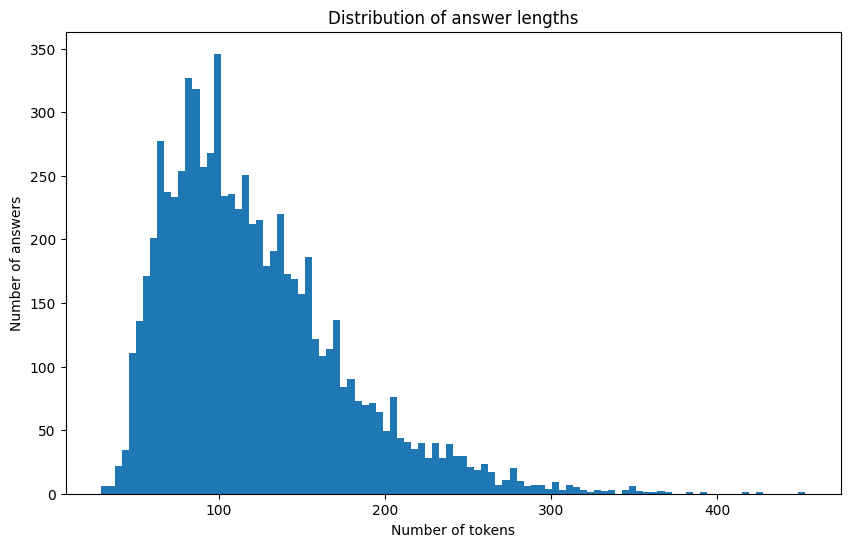

Average length: 121.7933
Minimum length: 29
Maximum length: 453


In [11]:
answers_len = []
answers_logic_steps = []
logic_steps_to_answer_len = defaultdict(list)

for i in range(len(train_dataset)):
    logic_steps = train_dataset[i]["logic_steps"]
    answer_len = len(tokenizer.encode(train_dataset[i]["answer"]))
    answers_logic_steps.append(logic_steps)
    answers_len.append(answer_len)
    logic_steps_to_answer_len[logic_steps].append(answer_len)

plt.figure(figsize=(10, 6))
plt.hist(answers_len, bins=100)
plt.title('Distribution of answer lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Number of answers')
plt.show()

print(f"Average length: {sum(answers_len) / len(answers_len):.4f}")
print(f"Minimum length: {min(answers_len)}")
print(f"Maximum length: {max(answers_len)}")

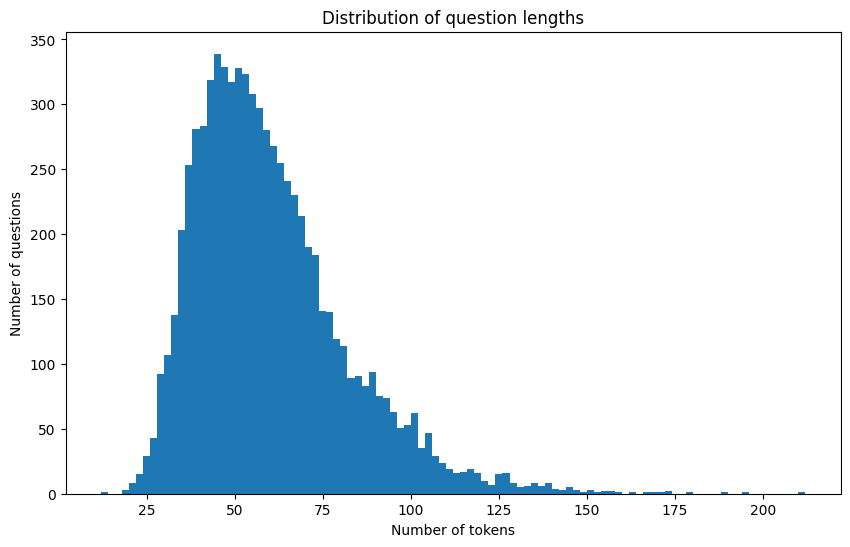

Average length: 59.6473
Minimum length: 12
Maximum length: 212


In [12]:
questions_len = []

for i in range(len(train_dataset)):
    questions_len.append(len(tokenizer.encode(train_dataset[i]["question"])))

plt.figure(figsize=(10, 6))
plt.hist(questions_len, bins=100)
plt.title('Distribution of question lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Number of questions')
plt.show()

print(f"Average length: {sum(questions_len) / len(questions_len):.4f}")
print(f"Minimum length: {min(questions_len)}")
print(f"Maximum length: {max(questions_len)}")

In [13]:
correlation, p_value = pearsonr(questions_len, answers_len)
print(f"Correlation coefficient between question and answer lens: {correlation:.4f} with p-value: {p_value:.4f}")

Correlation coefficient between question and answer lens: 0.5258 with p-value: 0.0000


In [14]:
correlation, p_value = pearsonr(answers_logic_steps, answers_len)
print(f"Corr coeff between required logic steps and answer lens: {correlation:.4f} with p-value: {p_value:.4f}")

Corr coeff between required logic steps and answer lens: 0.7711 with p-value: 0.0000


In [15]:
for key, value in sorted(logic_steps_to_answer_len.items()):
    print(f"If required {key} logic steps ({len(value)} questions):")
    print(f"Mean answer len: {sum(value) / len(value):.4f}")
    print(f"Min answer len: {min(value)}")
    print(f"Max answer len: {max(value)}")
    print(f"Variance: {np.var(value, ddof=1):.4f}")
    confidence = 0.975
    trim_max_id = int(len(value) * confidence)
    trim_max_value = sorted(value)[trim_max_id]
    print(f"Trimmed max ({confidence * 100:.1f}%):", trim_max_value)
    print()

If required 2 logic steps (1960 questions):
Mean answer len: 72.7102
Min answer len: 29
Max answer len: 172
Variance: 333.3606
Trimmed max (97.5%): 112

If required 3 logic steps (2149 questions):
Mean answer len: 105.6547
Min answer len: 36
Max answer len: 221
Variance: 636.6908
Trimmed max (97.5%): 163

If required 4 logic steps (1660 questions):
Mean answer len: 136.0554
Min answer len: 35
Max answer len: 273
Variance: 1073.7655
Trimmed max (97.5%): 210

If required 5 logic steps (954 questions):
Mean answer len: 169.2222
Min answer len: 51
Max answer len: 359
Variance: 1600.2423
Trimmed max (97.5%): 258

If required 6 logic steps (419 questions):
Mean answer len: 196.5155
Min answer len: 55
Max answer len: 369
Variance: 3021.2216
Trimmed max (97.5%): 305

If required 7 logic steps (228 questions):
Mean answer len: 207.5175
Min answer len: 64
Max answer len: 425
Variance: 5809.2904
Trimmed max (97.5%): 350

If required 8 logic steps (90 questions):
Mean answer len: 228.1000
Min answ

In [16]:
train_dataset = train_dataset.select(list(range(1960 + 2149 + 1660 + 954)))

In [17]:
R1_STYLE_SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. "
    "The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. "
    "The reasoning process and answer are enclosed within <reasoning> </reasoning> and "
    "<answer> </answer> tags, respectively, i.e., <reasoning> reasoning process here </reasoning>\n"
    "<answer> answer here </answer>."
)

TASK_SPECIFIC_INSTRUCTIONS = "The answer must be a single integer."

CONTENT_EXAMPLE = (
    "<reasoning>To calculate 2+2, we simply add the numbers together: 2 + 2 = 4.</reasoning>\n"
    "<answer>4</answer>"
)

def preprocess_dataset(dataset, chunk_size=1000):
    total_samples = len(dataset)
    print(f"Loaded {total_samples} samples")

    def extract_hash_answer(text: str) -> str | None:
        try:
            return text.split("####")[1].strip()
        except IndexError:
            return None

    def process_batch(batch):
        prompts = [[
            {'role': 'system', 'content': R1_STYLE_SYSTEM_PROMPT + "\n" + TASK_SPECIFIC_INSTRUCTIONS},
            {'role': 'user', 'content': "What is 2+2?"},
            {'role': 'assistant', 'content': CONTENT_EXAMPLE},
            {'role': 'user', 'content': q.strip()}
        ] for q in batch['question']]

        return {
            'prompt': prompts,
            'answer': batch['answer'],
            'num_answer': [extract_hash_answer(a) for a in batch['answer']],
        }

    return dataset.map(process_batch, batched=True, batch_size=chunk_size)

train_dataset = preprocess_dataset(train_dataset, chunk_size=500)

Loaded 6723 samples


Map:   0%|          | 0/6723 [00:00<?, ? examples/s]

In [18]:
print(json.dumps(train_dataset[0], indent=4))

{
    "question": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
    "answer": "Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72",
    "logic_steps": 2,
    "prompt": [
        {
            "content": "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <reasoning> </reasoning> and <answer> </answer> tags, respectively, i.e., <reasoning> reasoning process here </reasoning>\n<answer> answer here </answer>.\nThe answer must be a single integer.",
            "role": "system"
        },
        {
            "content": "What is 2+2?",
            "role": "user"
        },
        {
           

### Constants

In [19]:
max_prompt_length=512
max_completion_length=512
per_device_train_batch_size=8
num_generations=8
epochs_responses_save_interval=100
length_minimization_coef = 0.4
length_answer_cor_coef = 0.1
correct_answer_reward = 3.25
correct_format_reward = 1.5


### Reward functions and responses processing

In [20]:
def extract_xml_answer(text: str) -> str:
    try:
        answer = text.split("<answer>")[-1].split("</answer>")[0].strip()
        return answer
    except IndexError:
        return ""

def extract_xml_reasoning(text: str) -> str:
    try:
        answer = text.split("<reasoning>")[-1].split("</reasoning>")[0].strip()
        return answer
    except IndexError:
        return ""

In [21]:
questions_len = []
responses_len = []
answers_len = []
correctness = []
format_correctness = []
responses_data = defaultdict(list)

In [22]:
def print_everything(prompts, completions, answer, question, **kwargs):
    separator = "-" * 120
    print("\n")
    print("prompts: ", json.dumps(prompts, indent=4))
    print(separator)
    print("completion: ", json.dumps(completions, indent=4))
    print(separator)
    print("answer: ", json.dumps(answer, indent=4))
    print(separator)
    print("kwargs: ", json.dumps(kwargs, indent=4))
    print(separator)
    print(len(completions), len(prompts), len(prompts[0]), len(answer[0]))
    print("\n")

In [23]:
def format_reward_func(completions, **kwargs) -> list[float]:
    global format_correctness
    pattern = r"^<reasoning>.*?</reasoning>\s*<answer>\s*[+-]?\d*\.?\d+\s*</answer>$"
    responses = [completion[0]["content"] for completion in completions]
    matches = [bool(re.match(pattern, r)) for r in responses]
    print(''.join('⭐' if match else '❌' for match in matches), "\n")
    format_correctness += [1.0 if match else 0.0 for match in matches]
    return [correct_format_reward if match else 0.0 for match in matches]

def safe_data(question, responses, responses_correctness):
    global responses_data
    for question_id in range(len(question) // num_generations):
        cur_start_id = question_id * num_generations
        prompt = question[cur_start_id]
        extracted_anwers = []
        for generation_id in range(num_generations):
            cur_id = cur_start_id + generation_id
            if question[cur_id] != prompt:
                raise TypeError("Reward functions doesn't work properly")
            extracted_anwers.append((responses[cur_id], responses_correctness[cur_id] / correct_answer_reward))
        responses_data[prompt].append(extracted_anwers)

def log_data_for_wandb(questions, responses, answers, responses_correctness):
    global questions_len, responses_len, answers_len, correctness
    max_tokens_per_batch_responses = 0
    avg_tokens_per_batch_responses = 0
    local_questions_len = []
    local_responses_len = []
    local_answers_len = []
    for question, response, answer in zip(questions, responses, answers):
        local_questions_len.append(len(tokenizer.encode(question)))
        local_responses_len.append(len(tokenizer.encode(response)))
        local_answers_len.append(len(tokenizer.encode(answer)))

    questions_len += local_questions_len
    responses_len += local_responses_len
    answers_len += local_answers_len
    correctness += responses_correctness
    if wandb.run:
        wandb.log({
            "my_metrics/avg_response_tokens": np.mean(local_responses_len),
            "my_metrics/max_response_tokens": np.max(local_responses_len)
        })

def length_reward_func(prompts, completions, answer, num_answer, question, **kwargs) -> list[float]:
    # Execution time < 0.02s
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    np_responses_len = np.array([len(tokenizer.encode(response)) for response in responses])
    np_answers_len = np.array([len(tokenizer.encode(cur_answer)) for cur_answer in answer])
    correct = [1.0 if r == a else 0.0 for r, a in zip(extracted_responses, num_answer)]
    length_rewards = []
    for question_id in range(len(question) // num_generations):
        cur_start_id = question_id * num_generations
        prompt = question[cur_start_id]
        min_correct_len = max_completion_length + 1
        for cur_id in range(cur_start_id, cur_start_id + num_generations):
            if correct[cur_id] == 1:
                min_correct_len = min(min_correct_len, np_responses_len[cur_id])

        np_cur_responses_len = np_responses_len[cur_start_id:cur_start_id+num_generations]
        np_cur_anwers_len = np_answers_len[cur_start_id:cur_start_id+num_generations]
        cur_length_rewards = np.zeros(num_generations)
        correct_mean = sum(correct[cur_start_id:cur_start_id+num_generations]) / num_generations

        # Group optimization
        if sum(correct) > 0:
            opt_len_deviation = np.maximum(0, np_cur_responses_len - min_correct_len)
            if np.max(opt_len_deviation) != 0:
                opt_len_deviation = opt_len_deviation / np.max(opt_len_deviation)
                cur_length_rewards += -opt_len_deviation * length_minimization_coef * correct_mean

        # Deviation from answer len optimization
        opt_len_deviation = np.abs(np_cur_responses_len - np_cur_anwers_len)
        if np.max(opt_len_deviation) != 0:
            cur_length_rewards += -(opt_len_deviation / np.max(opt_len_deviation)) * length_answer_cor_coef

        length_rewards += cur_length_rewards.tolist()

    return length_rewards



def correctness_reward_func(prompts, completions, answer, num_answer, question, **kwargs) -> list[float]:
    responses = [completion[0]['content'] for completion in completions]
    extracted_responses = [extract_xml_answer(r) for r in responses]
    print(''.join('✅' if r == a else '❌' for r, a in zip(extracted_responses, num_answer)))
    responses_correctness = [correct_answer_reward if r == a else 0.0 for r, a in zip(extracted_responses, num_answer)]
    safe_data(question, responses, responses_correctness)
    log_data_for_wandb(question, responses, answer, responses_correctness)
    return responses_correctness

<a name="Train"></a>
### Train the model

Now set up GRPO Trainer and all configurations!

In [24]:
from trl import GRPOConfig, GRPOTrainer
from torch.utils.data import DataLoader

class CustomGRPOTrainer(GRPOTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.custom_step_callbacks = None
        self.step_count = 0
        self.epochs_responses_save_interval = 0

    def register_custom_callbacks(self, epochs_responses_save_interval, callbacks):
        self.custom_step_callbacks = callbacks
        self.epochs_responses_save_interval = epochs_responses_save_interval

    def training_step(self, *args, **kwargs):
        result = super().training_step(*args, **kwargs)
        self.step_count += 1
        if self.step_count % self.epochs_responses_save_interval == 0 and self.custom_step_callbacks:
            for custom_step_callback in self.custom_step_callbacks:
                custom_step_callback(self.step_count)
        return result

In [25]:
def custom_step_action(step):
    global responses_data

    print(f"\n--- Executing responses saving at step {step} ---")
    data_dir = "data_logs"
    os.makedirs(data_dir, exist_ok=True)
    filename = os.path.join(data_dir, f"responses_step_{step}.json")
    with open(filename, 'w', encoding='utf-8') as f:
            json.dump(dict(responses_data), f, indent=4, ensure_ascii=False)

    total_size = asizeof.asizeof(responses_data)
    print(f"Approx: {total_size / 1024 / 1024:.4f} MB")

    responses_data.clear()

def log_wandb(step):
    global questions_len, responses_len, answers_len, correctness, format_correctness

    if not wandb.run:
        return ""
    np_correctness = np.array(correctness) / correct_answer_reward
    np_format_correctness = np.array(format_correctness)
    np_answers_len = np.array(answers_len)
    np_responses_len = np.array(responses_len)

    baseline_efficiency = np.mean(np_correctness / (np_answers_len + 1e-6)) + 1e-9
    model_efficiency = np.mean(np_correctness / (np_responses_len + 1e-6))

    wandb.log({
        "my_metrics/question_vs_answer_length_correlation": pearsonr(questions_len, answers_len)[0],
        "my_metrics/question_vs_response_length_correlation": pearsonr(questions_len, responses_len)[0],
        "my_metrics/answer_vs_response_length_correlation": pearsonr(answers_len, responses_len)[0],
        "my_metrics/model_efficiency": model_efficiency / baseline_efficiency,
        "my_metrics/out_of_limit": np.mean(np_responses_len > max_completion_length - 2),
        "my_metrics/answer_correctness": np.mean(np_correctness),
        "my_metrics/format_correctness": np.mean(np_format_correctness),
    })
    questions_len.clear()
    responses_len.clear()
    answers_len.clear()
    correctness.clear()
    format_correctness.clear()

custom_step_callbacks = [custom_step_action, log_wandb]

In [26]:
training_args = GRPOConfig(
    use_vllm = True,
    learning_rate = 1e-5,
    seed=seed,
    beta=0.005,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.1,
    lr_scheduler_type = "constant_with_warmup",
    bf16=False,
    fp16=True,
    optim = "adamw_8bit",
    logging_steps = 15,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps = 4,
    num_generations=num_generations,
    max_prompt_length = max_prompt_length,
    max_completion_length = max_completion_length,
    num_train_epochs = 1,
    save_steps = 250,
    max_grad_norm = 0.1,
    max_steps = 1000,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    report_to = "wandb",
    output_dir = "outputs",
)

In [27]:
trainer = CustomGRPOTrainer(
    model = model,
    processing_class = tokenizer,
    reward_funcs = [
        correctness_reward_func,
        format_reward_func,
        length_reward_func
    ],
    args = training_args,
    train_dataset = train_dataset,
)

trainer.register_custom_callbacks(epochs_responses_save_interval, custom_step_callbacks)

In [28]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 6,723 | Num Epochs = 1 | Total steps = 1,000
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 4 x 1) = 32
 "-____-"     Trainable parameters = 35,192,832 of 529,225,600 (6.65% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


❌❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌✅✅❌❌❌❌❌✅
⭐⭐⭐⭐⭐⭐⭐❌❌⭐❌⭐❌⭐❌⭐❌❌❌❌❌❌⭐❌❌⭐⭐⭐❌⭐❌⭐ 

Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,reward,reward_std,completions / mean_length,completions / min_length,completions / max_length,completions / clipped_ratio,completions / mean_terminated_length,completions / min_terminated_length,completions / max_terminated_length,kl,rewards / correctness_reward_func / mean,rewards / correctness_reward_func / std,rewards / format_reward_func / mean,rewards / format_reward_func / std,rewards / length_reward_func / mean,rewards / length_reward_func / std
15,0.000000,0.774566,0.979468,144.054167,30.000000,488.466667,0.025000,134.721470,30.000000,397.800000,0.000028,0.264062,0.779668,0.556250,0.712565,-0.045746,0.045971
30,0.000000,0.898575,1.017765,125.347917,35.866667,375.200000,0.010417,121.397204,35.866667,337.866667,0.001112,0.209896,0.732906,0.737500,0.744425,-0.048821,0.041762
45,0.000100,1.137553,1.024019,110.279167,39.666667,379.666667,0.020833,101.836450,39.666667,299.733333,0.013217,0.236979,0.798580,0.950000,0.717855,-0.049427,0.044826
60,0.000800,1.225764,0.947782,100.493750,30.733333,292.866667,0.008333,97.364695,30.733333,258.466667,0.150806,0.230208,0.715096,1.050000,0.664871,-0.054444,0.040009
75,0.000200,1.458148,0.763611,89.750000,30.533333,242.733333,0.000000,89.750000,30.533333,242.733333,0.045048,0.230208,0.728100,1.284375,0.492855,-0.056435,0.039658
90,0.004300,1.554198,0.791043,101.960417,40.333333,272.333333,0.000000,101.960417,40.333333,272.333333,0.864609,0.304688,0.798345,1.306250,0.467499,-0.056740,0.046003
105,0.007000,1.715854,0.853527,105.708333,37.600000,257.200000,0.004167,104.590994,37.600000,238.200000,1.398056,0.372396,0.993949,1.400000,0.345957,-0.056541,0.049050
120,0.002600,1.692706,0.776300,111.906250,44.800000,269.533333,0.000000,111.906250,44.800000,269.533333,0.522904,0.331771,0.825851,1.418750,0.264574,-0.057815,0.045872
135,0.001900,1.913083,1.000200,118.562500,50.600000,248.533333,0.000000,118.562500,50.600000,248.533333,0.382560,0.548438,1.191984,1.434375,0.240610,-0.069730,0.060670
150,0.002000,1.919298,0.918945,122.947917,54.466667,290.266667,0.004167,121.354569,54.466667,250.666667,0.409731,0.575521,1.172122,1.415625,0.339541,-0.071848,0.067928


❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌✅❌❌
⭐⭐❌⭐⭐❌⭐❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌⭐❌❌❌⭐❌❌❌❌⭐ 

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌✅✅✅❌❌❌❌❌❌❌❌
⭐⭐⭐⭐❌❌❌⭐❌❌❌❌❌⭐❌❌❌❌❌❌⭐⭐⭐❌❌❌❌❌⭐❌⭐⭐ 

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌⭐⭐❌⭐⭐⭐❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌⭐❌❌ 

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
⭐❌⭐❌❌❌⭐❌⭐❌❌❌❌⭐⭐❌❌❌❌❌❌❌❌❌⭐⭐❌❌❌❌❌❌ 

❌❌❌❌❌❌❌❌❌✅❌❌✅✅❌❌❌❌❌❌❌❌❌❌❌❌❌✅✅✅✅✅
⭐❌❌⭐❌❌❌❌⭐⭐⭐❌❌⭐❌⭐⭐❌⭐❌⭐⭐❌⭐❌⭐⭐⭐❌❌⭐⭐ 

❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌❌❌❌❌❌⭐⭐❌❌❌⭐❌⭐❌⭐⭐⭐⭐❌❌⭐❌❌⭐⭐❌ 

❌❌❌❌❌❌✅✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
⭐❌⭐⭐❌❌❌⭐⭐❌❌⭐❌⭐❌⭐❌⭐❌❌❌❌⭐❌❌⭐⭐❌❌❌⭐❌ 

❌❌❌❌❌❌❌❌✅❌❌❌✅❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌❌❌❌⭐❌⭐❌⭐⭐⭐❌⭐❌⭐❌❌❌❌❌⭐⭐❌❌❌⭐❌❌❌❌ 

❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
⭐⭐❌❌❌❌❌❌❌❌⭐❌❌❌❌⭐❌❌❌❌❌❌❌⭐⭐❌❌❌⭐⭐⭐❌ 

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
⭐❌❌❌❌❌❌⭐⭐❌⭐❌❌❌❌⭐❌⭐⭐❌⭐⭐❌❌⭐⭐⭐⭐❌❌⭐❌ 

❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌
❌❌⭐⭐⭐⭐❌⭐❌⭐❌⭐⭐⭐❌❌⭐❌❌❌❌⭐❌❌⭐⭐⭐⭐⭐⭐❌⭐ 

❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
❌❌❌⭐❌❌❌❌❌❌⭐❌⭐❌❌❌❌⭐❌❌❌❌❌❌⭐❌❌❌❌❌⭐⭐ 

❌❌❌❌❌❌❌❌✅❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
⭐❌❌❌⭐⭐⭐❌⭐❌⭐❌⭐❌❌⭐❌⭐❌❌❌⭐⭐❌❌⭐⭐❌❌⭐⭐❌ 

❌❌❌❌❌❌❌❌✅✅✅❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌✅✅❌❌✅
⭐❌❌❌⭐⭐❌⭐❌❌⭐❌❌⭐❌⭐❌❌❌⭐❌❌⭐❌⭐❌❌⭐⭐❌❌⭐ 

❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌
⭐❌⭐⭐❌❌❌❌⭐⭐❌⭐⭐❌⭐

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


❌❌❌❌❌❌❌❌❌❌✅✅❌❌❌❌✅❌✅❌✅❌✅✅✅❌❌❌✅✅✅❌
⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌❌❌✅❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌
⭐⭐⭐⭐⭐⭐⭐⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌❌❌❌❌❌❌✅✅❌✅❌✅✅✅❌❌✅❌✅✅❌❌❌✅❌✅✅❌✅✅✅
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

✅❌❌✅❌✅✅❌❌✅✅✅❌✅❌✅❌✅✅❌❌❌❌❌❌❌✅❌❌❌❌❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌❌❌❌❌❌❌❌❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌❌
⭐⭐⭐⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐❌❌ 

✅❌✅✅✅✅✅✅❌❌✅✅❌❌❌✅✅✅✅✅❌❌✅✅✅✅✅❌✅❌❌✅
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌✅✅✅✅✅✅✅✅❌✅✅✅✅✅✅✅✅❌✅❌✅❌❌❌❌❌❌❌❌❌❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌❌✅❌❌❌✅❌❌❌❌❌❌✅❌❌❌❌✅❌❌❌✅❌❌❌❌❌❌❌❌❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌❌❌❌❌❌❌❌✅✅✅❌✅✅❌❌❌❌❌✅❌❌❌❌❌❌❌❌❌❌❌❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐❌⭐⭐⭐⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

✅✅✅❌✅❌✅✅❌❌❌❌❌❌❌❌❌❌❌❌✅✅❌❌❌✅✅✅✅✅✅❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌❌❌❌❌❌❌❌✅✅✅✅✅✅✅✅❌❌❌❌❌❌❌❌❌✅✅✅✅✅❌✅
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐❌⭐ 

❌❌❌❌❌❌✅❌✅✅✅✅✅✅✅✅❌✅❌❌❌❌❌❌✅✅❌❌❌❌❌❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

❌❌❌✅✅❌✅✅❌❌❌❌❌✅❌❌✅❌❌❌✅✅❌❌❌❌❌❌❌❌❌❌
⭐⭐❌⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

✅❌✅❌❌❌✅❌❌❌❌❌❌❌✅❌❌✅✅✅✅✅✅✅❌✅❌❌❌✅❌❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐ 

✅✅✅❌✅✅✅✅❌❌❌✅❌❌❌❌✅✅❌✅✅✅✅✅❌❌❌❌❌❌❌❌
⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐

TrainOutput(global_step=1000, training_loss=0.0034384183851070703, metrics={'train_runtime': 10240.2376, 'train_samples_per_second': 3.125, 'train_steps_per_second': 0.098, 'total_flos': 0.0, 'train_loss': 0.0034384183851070703})

### Get eval dataset

In [29]:
from datasets import load_dataset

In [30]:
def extract_xml_answer(text: str) -> str:
    try:
        answer = text.split("<answer>")[-1].split("</answer>")[0].strip()
        return answer
    except IndexError:
        return ""

def extract_xml_reasoning(text: str) -> str:
    try:
        answer = text.split("<reasoning>")[-1].split("</reasoning>")[0].strip()
        return answer
    except IndexError:
        return ""

In [31]:
dataset = load_dataset('json', data_files={
    # 'train': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl',
    'test': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl'
})['test']

Generating test split: 0 examples [00:00, ? examples/s]

In [32]:
R1_STYLE_SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. "
    "The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. "
    "The reasoning process and answer are enclosed within <reasoning> </reasoning> and "
    "<answer> </answer> tags, respectively, i.e., <reasoning> reasoning process here </reasoning>\n"
    "<answer> answer here </answer>."
)

TASK_SPECIFIC_INSTRUCTIONS = "The answer must be a single integer."

CONTENT_EXAMPLE = (
    "<reasoning>To calculate 2+2, we simply add the numbers together: 2 + 2 = 4.</reasoning>\n"
    "<answer>4</answer>"
)

def preprocess_dataset(dataset, chunk_size=1000):
    total_samples = len(dataset)
    print(f"Loaded {total_samples} samples")

    def extract_hash_answer(text: str) -> str | None:
        try:
            return text.split("####")[1].strip()
        except IndexError:
            return None

    def process_batch(batch):
        prompts = [[
            {'role': 'system', 'content': R1_STYLE_SYSTEM_PROMPT + "\n" + TASK_SPECIFIC_INSTRUCTIONS},
            {'role': 'user', 'content': "What is 2+2?"},
            {'role': 'assistant', 'content': CONTENT_EXAMPLE},
            {'role': 'user', 'content': q.strip()}
        ] for q in batch['question']]

        return {
            'prompt': prompts,
            'answer': batch['answer'],
            'num_answer': [extract_hash_answer(a) for a in batch['answer']],
        }

    return dataset.map(process_batch, batched=True, batch_size=chunk_size)

dataset = preprocess_dataset(dataset, chunk_size=500)

Loaded 1319 samples


Map:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [33]:
print(json.dumps(dataset[0], indent=4))

{
    "question": "Janet\u2019s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?",
    "answer": "Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eggs a day.\nShe makes 9 * 2 = $<<9*2=18>>18 every day at the farmer\u2019s market.\n#### 18",
    "prompt": [
        {
            "content": "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. The reasoning process and answer are enclosed within <reasoning> </reasoning> and <answer> </answer> tags, respectively, i.e., <reasoning> reasoning process here </reasoning>\n<answer> answer here </answer>.\nThe answer must be a single integer.",
            "role": "system"
   

### Eval after training

In [34]:
from vllm import LLM, SamplingParams
from tqdm.notebook import tqdm
from datetime import datetime

In [35]:
batch_size=16
lora_path = run_name + "_grpo_saved_lora"

In [36]:
model.save_lora(lora_path)

In [38]:
sampling_params = SamplingParams(
    temperature=0.0,
    max_tokens=4096,
    stop_token_ids=[tokenizer.eos_token_id],
)

total_samples = len(dataset)
results = []
correct = 0
total = 0
len_sum = 0
len_min = 4096
len_max = 0
correct_format = 0

def format_reward_func(response) -> float:
    pattern = r"^<reasoning>.*?</reasoning>\s*<answer>\s*[+-]?\d*\.?\d+\s*</answer>$"
    matched = bool(re.match(pattern, response))
    return int(matched)

progress_bar = tqdm(
    total=total_samples,
    desc="Processing samples",
    unit="examples",
    dynamic_ncols=True,
)

progress_bar.set_postfix({
    'acc': '0.00%',
    'correct': '0',
})


for i in range(0, total_samples, batch_size):
    batch_data = dataset[i:i + batch_size]
    current_batch_size = len(batch_data['prompt'])

    formatted_prompts = [
        tokenizer.apply_chat_template(
            p,
            tokenize=False,
            add_generation_prompt=True
        )
        for p in batch_data['prompt']
    ]

    outputs = model.fast_generate(
        formatted_prompts,
        sampling_params = sampling_params,
        lora_request = model.load_lora(lora_path),
    )

    for j, output in enumerate(outputs):
        response = output.outputs[0].text
        response_len = len(tokenizer.encode(response))

        generated_answer = extract_xml_answer(response)
        true_answer = batch_data['num_answer'][j]

        result = {
            'question': batch_data['question'][j],
            'true_answer': true_answer,
            'generated_answer': generated_answer,
            'full_response': response,
            'correct': generated_answer == true_answer,
            "response_len": response_len
        }
        results.append(result)

        if generated_answer == true_answer:
            correct += 1
        total += 1
        len_sum += response_len
        len_min = min(len_min, response_len)
        len_max = max(len_max, response_len)
        correct_format += format_reward_func(response)

    progress_bar.update(current_batch_size)
    progress_bar.set_postfix({
        'acc': f'{(correct/total)*100:.2f}%',
        'correct': f'{correct}/{total}',
    })

progress_bar.close()

Processing samples:   0%|          | 0/1319 [00:00<?, ?examples/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/16 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Processed prompts:   0%|          | 0/7 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

In [39]:
accuracy = correct / total if total > 0 else 0
metrics = {
    'accuracy': accuracy,
    'correct': correct,
    'format_accuracy': correct_format / total,
    'correct_format': correct_format,
    'total': total,
    'avg_len': len_sum / total,
    'len_min': len_min,
    'len_max': len_max,
    'timestamp': datetime.now().isoformat()
}

save_path = f"{run_name}_eval_results_{datetime.now().strftime('day_%d_time_%H_%M')}.json"
with open(save_path, 'w') as f:
    json.dump({
        'metrics': metrics,
        'results': results
    }, f, indent=4)
print(f"\nResults saved to {save_path}")

print("\nFinal Evaluation Results:")
print(f"Accuracy: {metrics['accuracy']:.2%}")
print(f"Correct: {metrics['correct']}/{metrics['total']}")

print(f"Format accuracy: {metrics['format_accuracy']:.2%}")
print(f"Correct format: {metrics['correct_format']}/{metrics['total']}")


Results saved to Group_method_with_ans_len_considering_GRPO_eval_results_day_21_time_18_31.json

Final Evaluation Results:
Accuracy: 35.41%
Correct: 467/1319
Format accuracy: 99.85%
Correct format: 1317/1319


In [44]:
from google.colab import files
files.download("Group_method_with_ans_len_considering_GRPO_grpo_saved_lora.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# This is auxiliary code (execution will cause an error)

### Model downloading

In [41]:
model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [02:10<00:00, 130.65s/it]


In [42]:
!zip model.zip -r model/

  adding: model/ (stored 0%)
  adding: model/tokenizer_config.json (deflated 89%)
  adding: model/vocab.json (deflated 61%)
  adding: model/tokenizer.json (deflated 81%)
  adding: model/model.safetensors


zip error: Interrupted (aborting)


In [43]:
os.rename('model.zip', run_name + '.zip')

FileNotFoundError: [Errno 2] No such file or directory: 'model.zip' -> 'Group_method_with_ans_len_considering_GRPO.zip'

In [ ]:
from google.colab import files
files.download(run_name + '.zip')

### Model upload

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip /content/drive/MyDrive/model.zip -d .

### Eval (after session restart)

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams
from tqdm.notebook import tqdm
import numpy as np
import re
import json
from datetime import datetime
import logging

#### Get eval dataset

In [ ]:
from datasets import load_dataset

In [ ]:
def extract_xml_answer(text: str) -> str:
    try:
        answer = text.split("<answer>")[-1].split("</answer>")[0].strip()
        return answer
    except IndexError:
        return ""

def extract_xml_reasoning(text: str) -> str:
    try:
        answer = text.split("<reasoning>")[-1].split("</reasoning>")[0].strip()
        return answer
    except IndexError:
        return ""

In [ ]:
dataset = load_dataset('json', data_files={
    # 'train': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl',
    'test': 'https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl'
})['test']

In [ ]:
R1_STYLE_SYSTEM_PROMPT = (
    "A conversation between User and Assistant. The user asks a question, and the Assistant solves it. "
    "The assistant first thinks about the reasoning process in the mind and then provides the user with the answer. "
    "The reasoning process and answer are enclosed within <reasoning> </reasoning> and "
    "<answer> </answer> tags, respectively, i.e., <reasoning> reasoning process here </reasoning>\n"
    "<answer> answer here </answer>."
)

TASK_SPECIFIC_INSTRUCTIONS = "The answer must be a single integer."

CONTENT_EXAMPLE = (
    "<reasoning>To calculate 2+2, we simply add the numbers together: 2 + 2 = 4.</reasoning>\n"
    "<answer>4</answer>"
)

def preprocess_dataset(dataset, chunk_size=1000):
    total_samples = len(dataset)
    print(f"Loaded {total_samples} samples")

    def extract_hash_answer(text: str) -> str | None:
        try:
            return text.split("####")[1].strip()
        except IndexError:
            return None

    def process_batch(batch):
        prompts = [[
            {'role': 'system', 'content': R1_STYLE_SYSTEM_PROMPT + "\n" + TASK_SPECIFIC_INSTRUCTIONS},
            {'role': 'user', 'content': "What is 2+2?"},
            {'role': 'assistant', 'content': CONTENT_EXAMPLE},
            {'role': 'user', 'content': q.strip()}
        ] for q in batch['question']]

        return {
            'prompt': prompts,
            'answer': batch['answer'],
            'num_answer': [extract_hash_answer(a) for a in batch['answer']],
        }

    return dataset.map(process_batch, batched=True, batch_size=chunk_size)

dataset = preprocess_dataset(dataset, chunk_size=500)

In [ ]:
print(json.dumps(dataset[0], indent=4))

#### Download the model

In [ ]:
gpu_memory_utilization=0.8
batch_size=16

model_path="model/"

In [ ]:
with tqdm(total=2, desc="Loading model components") as pbar:
    llm = LLM(
        model=model_path,
        dtype="half",
        gpu_memory_utilization=gpu_memory_utilization,
        max_model_len=4096,
        device="cuda:0",
        enable_chunked_prefill=True,
    )
    pbar.update(1)

    tokenizer = AutoTokenizer.from_pretrained(
        model_path,
        model_max_length=4096,
        padding_side='right',
        truncation_side='right'
    )
    pbar.update(1)

In [ ]:
def format_reward_func(response) -> float:
    pattern = r"^<reasoning>.*?</reasoning>\s*<answer>\s*[+-]?\d*\.?\d+\s*</answer>$"
    matched = bool(re.match(pattern, response))
    return int(matched)

In [ ]:
sampling_params = SamplingParams(
    temperature=0.0,
    max_tokens=4096,
    stop_token_ids=[tokenizer.eos_token_id],
)

total_samples = len(dataset)
results = []
correct = 0
total = 0
len_sum = 0
len_min = 4096
len_max = 0
correct_format = 0

progress_bar = tqdm(
    total=total_samples,
    desc="Processing samples",
    unit="examples",
    dynamic_ncols=True,
)

progress_bar.set_postfix({
    'acc': '0.00%',
    'correct': '0',
})


for i in range(0, total_samples, batch_size):
    batch_data = dataset[i:i + batch_size]
    current_batch_size = len(batch_data['prompt'])

    formatted_prompts = [
        tokenizer.apply_chat_template(
            p,
            tokenize=False,
            add_generation_prompt=True
        )
        for p in batch_data['prompt']
    ]

    outputs = llm.generate(
        formatted_prompts,
        sampling_params,
    )

    for j, output in enumerate(outputs):
        response = output.outputs[0].text
        response_len = len(tokenizer.encode(response))

        generated_answer = extract_xml_answer(response)
        true_answer = batch_data['num_answer'][j]

        result = {
            'question': batch_data['question'][j],
            'true_answer': true_answer,
            'generated_answer': generated_answer,
            'full_response': response,
            'correct': generated_answer == true_answer,
            "response_len": response_len
        }
        results.append(result)

        if generated_answer == true_answer:
            correct += 1
        total += 1
        len_sum += response_len
        len_min = min(len_min, response_len)
        len_max = max(len_max, response_len)
        correct_format += format_reward_func(response)

    progress_bar.update(current_batch_size)
    progress_bar.set_postfix({
        'acc': f'{(correct/total)*100:.2f}%',
        'correct': f'{correct}/{total}',
    })

progress_bar.close()

In [ ]:
accuracy = correct / total if total > 0 else 0
metrics = {
    'accuracy': accuracy,
    'correct': correct,
    'format_accuracy': correct_format / total,
    'correct_format': correct_format,
    'total': total,
    'avg_len': len_sum / total,
    'len_min': len_min,
    'len_max': len_max,
    'model_path': model_path,
    'timestamp': datetime.now().isoformat()
}

save_path = f"gsm8k_eval_results_{datetime.now().strftime('day_%d_time_%H_%M')}.json"
with open(save_path, 'w') as f:
    json.dump({
        'metrics': metrics,
        'results': results
    }, f, indent=4)
print(f"\nResults saved to {save_path}")

print("\nFinal Evaluation Results:")
print(f"Accuracy: {metrics['accuracy']:.2%}")
print(f"Correct: {metrics['correct']}/{metrics['total']}")

print(f"Format accuracy: {metrics['format_accuracy']:.2%}")
print(f"Correct format: {metrics['correct_format']}/{metrics['total']}")

In [ ]:
from google.colab import files
files.download(save_path)

### Manual Inference
Now let's try the model we just trained! First, let's first try the model without any GRPO trained:

In [ ]:
text = [tokenizer.apply_chat_template([
    {"role" : "user", "content" : "How many r's are in strawberry?"},
], tokenize = False, add_generation_prompt = True)]
text.append(text[0])

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = None,
)

output

In [ ]:
output[1].outputs[0].text

In [ ]:
model.save_lora("grpo_saved_lora")

In [ ]:
text = tokenizer.apply_chat_template([
    {"role" : "system", "content" : R1_STYLE_SYSTEM_PROMPT},
    {"role" : "user", "content" : "How many r's are in strawberry?"},
], tokenize = False, add_generation_prompt = True)

from vllm import SamplingParams
sampling_params = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 1024,
)
output = model.fast_generate(
    text,
    sampling_params = sampling_params,
    lora_request = model.load_lora("grpo_saved_lora"),
)[0].outputs[0].text

output